# Preprocessing et Tokenization MIDI

## Objectif
Transformation des fichiers MIDI en séquences de tokens pour pouvoir les utiliser avec un transformer.

Ici on va utilier REMI qui permet de 'réécrire' les MIDI en tokens pour qu'ils puissent être compris par le transformer

In [1]:
# Imports
import json
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from miditok import REMI, TokenizerConfig

import warnings
warnings.filterwarnings('ignore')

# Configuration
%matplotlib inline

## 1. Configuration des Chemins

In [4]:
# Chemins du projet
MAESTRO_DIR = Path("../../data/maestro/maestro-v3.0.0")
JSON_PATH = MAESTRO_DIR / "maestro-v3.0.0.json"
PROCESSED_DIR = Path("../data/processed")
TOKENIZER_PATH = PROCESSED_DIR / "tokenizer"

# On créer les dossiers
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
TOKENIZER_PATH.mkdir(parents=True, exist_ok=True)

print("Chemins configurés")
print(f"MAESTRO : {MAESTRO_DIR}")
print(f"Output  : {PROCESSED_DIR}")

Chemins configurés
MAESTRO : ..\..\data\maestro\maestro-v3.0.0
Output  : ..\data\processed


## 2. Configuration du Tokenizer REMI

In [ ]:
# Configuration du tokenizer
config = TokenizerConfig(
    num_velocities=32,           # 32 niveaux de vélocité (0-127 → 32 bins)
    use_chords=False,            # Pas de détection d'accords (on veut les notes individuelles)
    use_rests=True,              # Pas de silences explicites (géré par time_shift)
    use_tempos=True,             # Conserver les tempos
    use_time_signatures=True,    # Conserver les signatures temporelles
    use_programs=False,          # Pas besoin (piano uniquement dans MAESTRO)
    beat_res={(0, 12): 8},  # Résolution temporelle
    nb_velocities=32,
)

print("Configuration du tokenizer créée")
print("Paramètres :")
for key, value in config.__dict__.items():
    if not key.startswith('_'):
        print(f"  {key:25s}: {value}")

Configuration du tokenizer créée
Paramètres :
  pitch_range              : (21, 109)
  beat_res                 : {(0, 12): 8}
  num_velocities           : 32
  remove_duplicated_notes  : False
  encode_ids_split         : bar
  special_tokens           : ['PAD_None', 'BOS_None', 'EOS_None', 'MASK_None']
  use_velocities           : True
  use_note_duration_programs: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, -1}
  use_chords               : False
  use_rests                : True
  use_tempos              

In [32]:
# Créer le tokenizer REMI
tokenizer = REMI(config)

print("Tokenizer REMI créé")
print(f"Taille initiale du vocabulaire: {len(tokenizer)} tokens")

Tokenizer REMI créé
Taille initiale du vocabulaire: 453 tokens


## 3. Test du Tokenizer sur un Fichier

In [33]:
# Charger les métadonnées
with open(JSON_PATH, 'r') as f:
    data = json.load(f)

# On récupère le nombre d'entrées depuis n'importe quelle clé
num_entries = len(data['midi_filename'])
print(f"{num_entries} entrées trouvées")

metadata = []
for i in range(num_entries):
    entry = {}
    # Pour chaque clé, on récupère la valeur
    for key in data.keys():
        entry[key] = data[key][str(i)]
    metadata.append(entry)

print(f"{len(metadata)} entrées chargées")

# On test sur le premier fichier
test_entry = metadata[0]
test_midi_path = MAESTRO_DIR / test_entry['midi_filename']

print(f"Test sur un fichier")
print(f"Titre : {test_entry['canonical_title']}")
print(f"Compositeur : {test_entry['canonical_composer']}")
print(f"Chemin : {test_entry['midi_filename']}")

1276 entrées trouvées
1276 entrées chargées
Test sur un fichier
Titre : Sonata Op. 1
Compositeur : Alban Berg
Chemin : 2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi


In [34]:
# Tokenizer le fichier
try:
    tokens = tokenizer(test_midi_path)
    
    # On gère les différents formats de sortie (suite à problème avec miditok)
    if hasattr(tokens, 'ids') :
        token_ids = tokens.ids
    elif isinstance(tokens, list):
        if len(tokens) > 0 and hasattr(tokens[0], 'ids') :
            token_ids = tokens[0].ids
        else:
            token_ids = tokens
    else:
        token_ids = list(tokens)
    
    print(f"Tokenization réussie!")
    print(f"Nombre de tokens : {len(token_ids)}")
    print(f"Premiers tokens : {token_ids[:10]}")
    print(f"Range des tokens : [{min(token_ids)}, {max(token_ids)}]")
    
    # Visualisation du décodage des 10 premiers tokens
    print(f"Décodage des 10 premiers tokens :")
    for i, token_id in enumerate(token_ids[:10]):
        # Utiliser la méthode correcte pour décoder
        try:
            token_str = tokenizer.vocab[token_id]
        except:
            token_str = f"Token_{token_id}"
        print(f"  Token {i}: {token_id:4d} -> {token_str}")
        
except Exception as e:
    print(f"Erreur lors de la tokenization: {e}")

Tokenization réussie!
Nombre de tokens : 15992
Premiers tokens : [4, 452, 222, 424, 391, 238, 51, 106, 138, 251]
Range des tokens : [4, 452]
Décodage des 10 premiers tokens :
  Token 0:    4 -> Token_4
  Token 1:  452 -> Token_452
  Token 2:  222 -> Token_222
  Token 3:  424 -> Token_424
  Token 4:  391 -> Token_391
  Token 5:  238 -> Token_238
  Token 6:   51 -> Token_51
  Token 7:  106 -> Token_106
  Token 8:  138 -> Token_138
  Token 9:  251 -> Token_251


## 4. Entraînement du Vocabulaire BPE (Byte Pair Encoding)

Ca permet de créer un vocabulaire plus compact en fusionnant les paires de tokens fréquentes. (Pas du tout adapté à la musique à priori)

In [35]:
# Choisir si on veut entraîner BPE
USE_BPE = False  # Mettre True pour utiliser BPE

if USE_BPE:
    train_files = [
        MAESTRO_DIR / entry['midi_filename']
        for entry in metadata
        if entry['split'] == 'train'
    ]
    
    print(f"Nombre de fichiers pour entraîner BPE: {len(train_files)}")
    
    # Entraîner BPE avec le vocabulaire complet
    tokenizer.learn_bpe(
        vocab_size=10000,              # Vocabulaire cible
        files_paths=train_files,       
        start_from_empty_voc=False     # On garde les tokens de base
    )
    
    print(f"✓ BPE entraîné")
    print(f"  Taille finale du vocabulaire: {len(tokenizer)} tokens")
    
    # Vérifier que le BPE a vraiment fonctionné
    if len(tokenizer.vocab) > 500:
        print(f"  ✓ BPE réussi ! Vocabulaire étendu à {len(tokenizer.vocab)} tokens")
    else:
        print(f"  ⚠️ Attention: Le vocabulaire est petit ({len(tokenizer.vocab)} tokens)")
        print(f"     Le BPE n'a peut-être pas fonctionné correctement")
else:
    print("⏭️ Skip BPE (vocabulaire de base utilisé)")
    print(f"  Taille du vocabulaire: {len(tokenizer)} tokens")

⏭️ Skip BPE (vocabulaire de base utilisé)
  Taille du vocabulaire: 453 tokens


In [ ]:
# Vérifier le vocabulaire
print(f"Tokens dans le vocab : {list(tokenizer.vocab.keys())}")
# Ce sont les séquences de tokens (Padding, Beginning Of Sequence, etc...)

Tokens dans le vocab : ['PAD_None', 'BOS_None', 'EOS_None', 'MASK_None', 'Bar_None', 'Pitch_21', 'Pitch_22', 'Pitch_23', 'Pitch_24', 'Pitch_25', 'Pitch_26', 'Pitch_27', 'Pitch_28', 'Pitch_29', 'Pitch_30', 'Pitch_31', 'Pitch_32', 'Pitch_33', 'Pitch_34', 'Pitch_35', 'Pitch_36', 'Pitch_37', 'Pitch_38', 'Pitch_39', 'Pitch_40', 'Pitch_41', 'Pitch_42', 'Pitch_43', 'Pitch_44', 'Pitch_45', 'Pitch_46', 'Pitch_47', 'Pitch_48', 'Pitch_49', 'Pitch_50', 'Pitch_51', 'Pitch_52', 'Pitch_53', 'Pitch_54', 'Pitch_55', 'Pitch_56', 'Pitch_57', 'Pitch_58', 'Pitch_59', 'Pitch_60', 'Pitch_61', 'Pitch_62', 'Pitch_63', 'Pitch_64', 'Pitch_65', 'Pitch_66', 'Pitch_67', 'Pitch_68', 'Pitch_69', 'Pitch_70', 'Pitch_71', 'Pitch_72', 'Pitch_73', 'Pitch_74', 'Pitch_75', 'Pitch_76', 'Pitch_77', 'Pitch_78', 'Pitch_79', 'Pitch_80', 'Pitch_81', 'Pitch_82', 'Pitch_83', 'Pitch_84', 'Pitch_85', 'Pitch_86', 'Pitch_87', 'Pitch_88', 'Pitch_89', 'Pitch_90', 'Pitch_91', 'Pitch_92', 'Pitch_93', 'Pitch_94', 'Pitch_95', 'Pitch_96', 'Pi

In [40]:
# Sauvegarder le tokenizer
tokenizer.save(TOKENIZER_PATH)
print(f"✓ Tokenizer sauvegardé dans: {TOKENIZER_PATH}")

✓ Tokenizer sauvegardé dans: ..\data\processed\tokenizer


In [41]:
# Sauvegarder aussi le tokenizer en pickle pour faciliter le chargement

tokenizer_pickle_path = PROCESSED_DIR / "tokenizer/tokenizer_complete.pkl"
with open(tokenizer_pickle_path, 'wb') as f:
    pickle.dump(tokenizer, f)

print(f"Tokenizer aussi sauvegardé en pickle: {tokenizer_pickle_path}")

Tokenizer aussi sauvegardé en pickle: ..\data\processed\tokenizer\tokenizer_complete.pkl


## 5. Tokenization du Dataset Complet

Ici on les découpe en séquences de longueur fixe pour le transformer

In [ ]:
# Hyperparamètres
MAX_SEQ_LEN = 1024
MIN_SEQ_LEN = 32
STRIDE = 512 # Overlap entre séquences (On chevauche de 50%)

print(f"Configuration du découpage:")
print(f"MAX_SEQ_LEN : {MAX_SEQ_LEN} tokens")
print(f"MIN_SEQ_LEN : {MIN_SEQ_LEN} tokens")
print(f"STRIDE      : {STRIDE} tokens")

Configuration du découpage:
MAX_SEQ_LEN : 1024 tokens
MIN_SEQ_LEN : 32 tokens
STRIDE      : 512 tokens


In [43]:
def tokenize_and_split(midi_path, tokenizer, max_len=1024, min_len=32, stride=512):
    """
    Tokenize un fichier MIDI et le découpe en séquences.
    """
    try:
        # Tokenization du fichier
        tokens = tokenizer(midi_path)
        
        # On gère les différents formats de sortie de miditok (toujours le même problème rencontré)
        if hasattr(tokens, 'ids'):
            token_ids = tokens.ids
        elif isinstance(tokens, list):
            # Liste de séquence tokenisée (multi-track)
            if len(tokens) > 0 and hasattr(tokens[0], 'ids'):
                token_ids = tokens[0].ids  # On prend le premier
            # Liste d'ID
            elif len(tokens) > 0 and isinstance(tokens[0], int):
                token_ids = tokens
            else:
                return []
        else:
            token_ids = list(tokens)
        
        if not token_ids or len(token_ids) == 0:
            return []
        
        # Découpage en séquences
        sequences = []
        for i in range(0, len(token_ids), stride):
            seq = token_ids[i:i + max_len]
            
            if len(seq) >= min_len:
                sequences.append(seq)
        
        return sequences
    
    except Exception as e:
        print(f"Erreur avec {midi_path.name}: {e}")
        return []

In [45]:
def process_split(metadata, split_name, tokenizer, maestro_dir, 
                  max_len=1024, min_len=32, stride=512, max_files=None):
    # Filtrer les fichiers du split qu'on veut
    split_files = [
        maestro_dir / entry['midi_filename']
        for entry in metadata
        if entry['split'] == split_name
    ]
    
    if max_files:
        split_files = split_files[:max_files]
    
    print(f"Processing split: {split_name}")
    print(f"Nombre de fichiers: {len(split_files)}")
    
    # Tokenizer chaque fichier
    all_sequences = []
    failed_count = 0
    
    for midi_path in tqdm(split_files, desc=f"Tokenizing {split_name}"):
        sequences = tokenize_and_split(
            midi_path, tokenizer,
            max_len=max_len,
            min_len=min_len,
            stride=stride
        )
        
        if sequences:
            all_sequences.extend(sequences)
        else:
            failed_count += 1
    
    print(f"{len(all_sequences)} séquences créées")
    print(f"{failed_count} fichiers échoués")
    
    return all_sequences

### Processing de tous les splits

In [46]:
debug = False 
debug_max_files = 10  # Nombre de fichiers max

if debug:
    max_files = debug_max_files
else:
    max_files = None

In [ ]:
# On fait le processing sur tous les split
processed_data = {}

for split_name in ['train', 'validation', 'test']:
    sequences = process_split(
        metadata=metadata,
        split_name=split_name,
        tokenizer=tokenizer,
        maestro_dir=MAESTRO_DIR,
        max_len=MAX_SEQ_LEN,
        min_len=MIN_SEQ_LEN,
        stride=STRIDE,
        max_files=max_files
    )
    
    processed_data[split_name] = sequences
    
    # Statistiques
    lengths = [len(seq) for seq in sequences]
    print(f"Statistiques {split_name}:")
    print(f"Nombre de séquences : {len(sequences)}")
    print(f"Longueur moyenne    : {np.mean(lengths):.1f} tokens")
    print(f"Longueur médiane    : {np.median(lengths):.1f} tokens")
    print(f"Min / Max           : {min(lengths)} / {max(lengths)} tokens")


Processing split: train
Nombre de fichiers: 962


Tokenizing train:   0%|          | 0/962 [00:00<?, ?it/s]

42318 séquences créées
0 fichiers échoués
Statistiques train:
Nombre de séquences : 42318
Longueur moyenne    : 1001.8 tokens
Longueur médiane    : 1024.0 tokens
Min / Max           : 32 / 1024 tokens
Processing split: validation
Nombre de fichiers: 137


Tokenizing validation:   0%|          | 0/137 [00:00<?, ?it/s]

4801 séquences créées
0 fichiers échoués
Statistiques validation:
Nombre de séquences : 4801
Longueur moyenne    : 996.3 tokens
Longueur médiane    : 1024.0 tokens
Min / Max           : 41 / 1024 tokens
Processing split: test
Nombre de fichiers: 177


Tokenizing test:   0%|          | 0/177 [00:00<?, ?it/s]

5534 séquences créées
0 fichiers échoués
Statistiques test:
Nombre de séquences : 5534
Longueur moyenne    : 992.8 tokens
Longueur médiane    : 1024.0 tokens
Min / Max           : 33 / 1024 tokens

✓ TOKENIZATION TERMINÉE


## 6. Sauvegarde des Données Preprocessées

In [50]:
# Sauvegarder chaque split
for split_name, sequences in processed_data.items():
    output_path = PROCESSED_DIR / f"{split_name}_sequences.pkl"
    
    with open(output_path, 'wb') as f:
        pickle.dump(sequences, f)
    
    print(f"Sauvegardé: {output_path} ({len(sequences)} séquences)")

Sauvegardé: ..\data\processed\train_sequences.pkl (42318 séquences)
Sauvegardé: ..\data\processed\validation_sequences.pkl (4801 séquences)
Sauvegardé: ..\data\processed\test_sequences.pkl (5534 séquences)


In [53]:
# Sauvegarde des métadonnées du preprocessing
preprocessing_info = {
    'tokenizer_type': 'REMI',
    'vocab_size': len(tokenizer),
    'max_seq_len': MAX_SEQ_LEN,
    'min_seq_len': MIN_SEQ_LEN,
    'stride': STRIDE,
    'num_velocities': config.num_velocities,
    'train_sequences': len(processed_data['train']),
    'val_sequences': len(processed_data['validation']),
    'test_sequences': len(processed_data['test']),
}

info_path = PROCESSED_DIR / "preprocessing_info.json"
with open(info_path, 'w') as f:
    json.dump(preprocessing_info, f, indent=2)

print(f"Métadonnées sauvegardées : {info_path}")

Métadonnées sauvegardées : ..\data\processed\preprocessing_info.json


## 7. Visualisation des Données Tokenizées

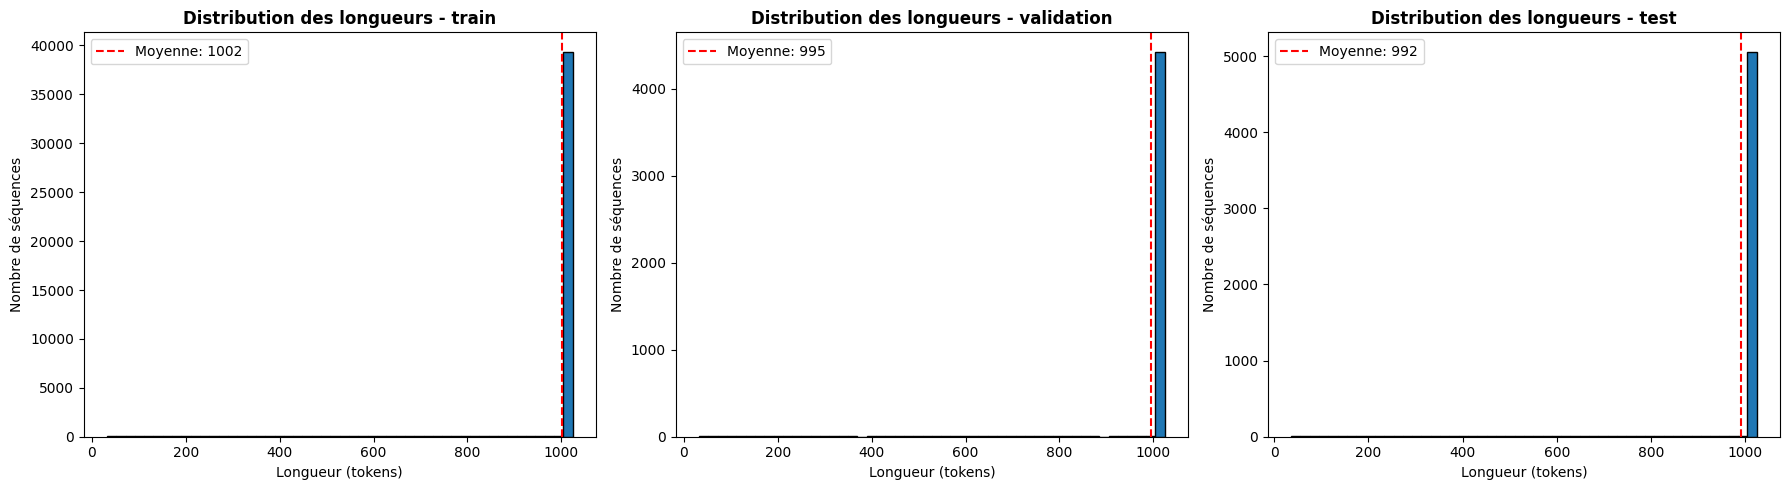

In [ ]:
# On vérifie la distribution des longueurs de séquences
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (split_name, sequences) in enumerate(processed_data.items()):
    lengths = [len(seq) for seq in sequences]
    
    axes[idx].hist(lengths, bins=50, edgecolor='black')
    axes[idx].set_title(f'Distribution des longueurs - {split_name}', fontweight='bold')
    axes[idx].set_xlabel('Longueur (tokens)')
    axes[idx].set_ylabel('Nombre de séquences')
    axes[idx].axvline(np.mean(lengths), color='red', linestyle='--',
                     label=f'Moyenne: {np.mean(lengths):.0f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

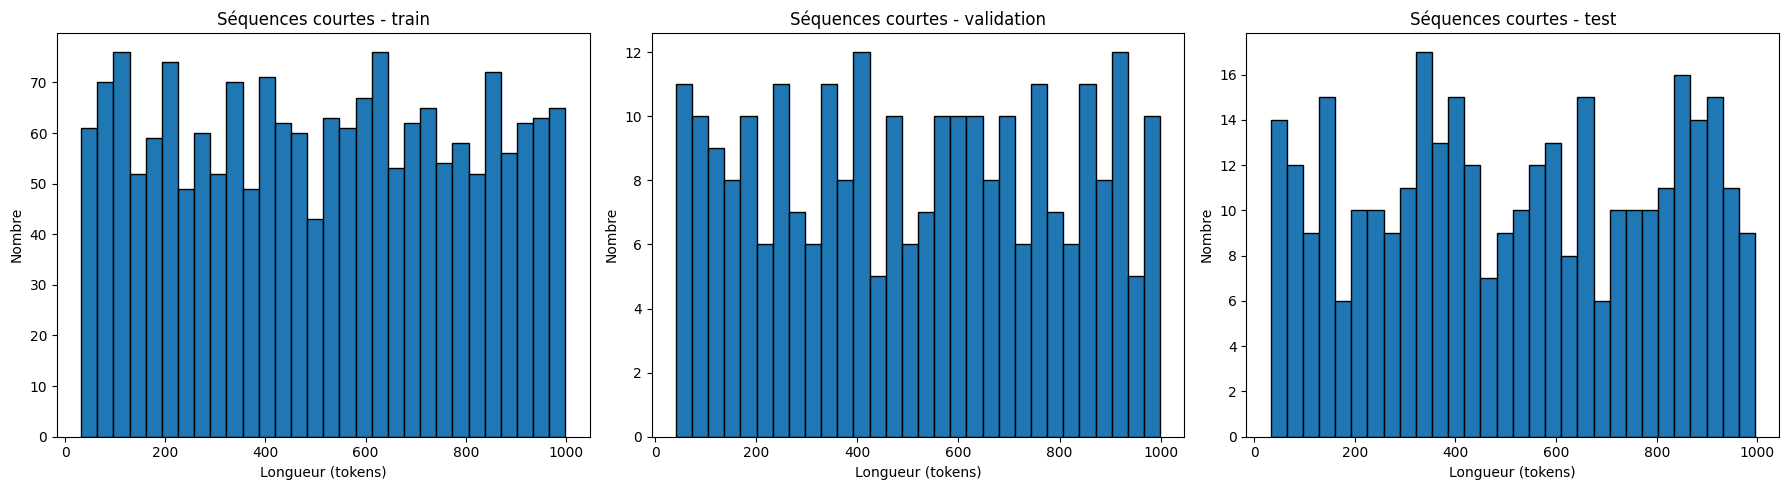

In [ ]:
# Zoom sur les séquences < 1000 tokens
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (split_name, sequences) in enumerate(processed_data.items()):
    lengths = [len(seq) for seq in sequences]
    
    short_lengths = [l for l in lengths if l < 1000]
    
    if short_lengths:
        axes[idx].hist(short_lengths, bins=30, edgecolor='black')
        axes[idx].set_title(f'Séquences courtes - {split_name}')
        axes[idx].set_xlabel('Longueur (tokens)')
        axes[idx].set_ylabel('Nombre')
    else:
        axes[idx].text(0.5, 0.5, 'Aucune séquence < 1000', 
                       ha='center', va='center')

plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter

# Analyse du vocabulaire utilisé

id_to_token = {v: k for k, v in tokenizer.vocab.items()}

# nombre de tokens du train
all_tokens = [token for seq in processed_data['train'] for token in seq]
token_counts = Counter(all_tokens)

print(f"Nombre total de tokens (train): {len(all_tokens):,}")
print(f"Tokens uniques utilisés: {len(token_counts)}")
print(f"Taille du vocabulaire: {len(tokenizer)}")

print("Les 10 tokens les plus fréquents:")
for token_id, count in token_counts.most_common(10):
    token_str = id_to_token[token_id]
    percentage = (count / len(all_tokens)) * 100
    print(f"{token_id:4d} {token_str:25s} {count:10d} ({percentage:5.2f}%)")


Analyse du vocabulaire utilisé:
Nombre total de tokens (train): 42,395,311
Tokens uniques utilisés: 283
Taille du vocabulaire: 453
Les 10 tokens les plus fréquents:
 126 Duration_0.1.8               5836687 (13.77%)
 127 Duration_0.2.8               2009205 ( 4.74%)
 380 Rest_0.1.8                    895437 ( 2.11%)
 111 Velocity_71                   881258 ( 2.08%)
 128 Duration_0.3.8                878556 ( 2.07%)
 112 Velocity_75                   865918 ( 2.04%)
 110 Velocity_67                   862972 ( 2.04%)
 109 Velocity_63                   827325 ( 1.95%)
 113 Velocity_79                   823896 ( 1.94%)
 108 Velocity_59                   774202 ( 1.83%)


In [ ]:
# Visualiser une séquence exemple
if processed_data['train']:  # Vérifier qu'il y a des séquences
    example_seq = processed_data['train'][0][:20]  # 20 premiers tokens
    
    print("Exemple de séquence tokenizée (20 premiers tokens) :")
    for i, token_id in enumerate(example_seq[:20]):
        try:
            token_str = tokenizer.vocab[token_id]
        except:
            token_str = f"Token_{token_id}"
        print(f"{i:3d}. {token_id:4d} → {token_str}")
else:
    print("Aucune séquence disponible pour l'exemple")

Exemple de séquence tokenizée (20 premiers tokens) :
  0.    4 → Token_4
  1.  452 → Token_452
  2.  222 → Token_222
  3.  424 → Token_424
  4.  391 → Token_391
  5.  238 → Token_238
  6.   51 → Token_51
  7.  106 → Token_106
  8.  138 → Token_138
  9.  251 → Token_251
 10.   56 → Token_56
 11.  110 → Token_110
 12.  127 → Token_127
 13.  382 → Token_382
 14.  224 → Token_224
 15.   62 → Token_62
 16.  110 → Token_110
 17.  148 → Token_148
 18.   55 → Token_55
 19.  105 → Token_105
